In [1]:
pip install pyspark

     |████████████████████████████████| 204.8MB 68kB/s 
     |████████████████████████████████| 204kB 45.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.2-py2.py3-none-any.whl size=205186687 sha256=b88de0e99cbb1904888e1685102361fceae2183e38657ba55b406b269d04de9a
  Stored in directory: /root/.cache/pip/wheels/8b/09/da/c1f2859bcc86375dc972c5b6af4881b3603269bcc4c9be5d16
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [3]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

In [4]:
df=spark.read.csv('/content/drive/MyDrive/datacamp/iris_dataset.csv',inferSchema=True,header=True)

In [5]:
print((df.count(),len(df.columns)))

(150, 5)


In [6]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [7]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [8]:
df.orderBy(rand()).show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|5.6         |3.0        |4.1         |1.3        |versicolor|
|7.3         |2.9        |6.3         |1.8        |virginica |
|5.0         |3.4        |1.5         |0.2        |setosa    |
|4.5         |2.3        |1.3         |0.3        |setosa    |
|6.4         |3.2        |4.5         |1.5        |versicolor|
|4.4         |3.2        |1.3         |0.2        |setosa    |
|5.7         |2.8        |4.1         |1.3        |versicolor|
|5.0         |3.2        |1.2         |0.2        |setosa    |
|6.7         |3.1        |4.7         |1.5        |versicolor|
|5.1         |3.4        |1.5         |0.2        |setosa    |
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [9]:
df.select('species').distinct().count()

3

In [10]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [12]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [13]:
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [19]:
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(wssse))
    print('--'*30)

AttributeError: ignored

In [20]:
#cluster_number = range(2,10)
#plt.scatter(cluster_number,errors)
#plt.xlabel('Number of Clusters (K)')
#plt.ylabel('SSE')
#plt.show()

In [21]:
kmeans = KMeans(featuresCol='features',k=3,)

In [22]:
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   38|
|         0|   62|
+----------+-----+



In [23]:
predictions=model.transform(final_data)

In [24]:
predictions.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

In [25]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
| virginica|         0|   14|
|versicolor|         0|   48|
|    setosa|         1|   50|
|versicolor|         2|    2|
+----------+----------+-----+



In [26]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",1
100,6.3,3.3,6.0,2.5,virginica,"[6.3, 3.3, 6.0, 2.5]",2
99,5.7,2.8,4.1,1.3,versicolor,"[5.7, 2.8, 4.1, 1.3]",0
20,5.4,3.4,1.7,0.2,setosa,"[5.4, 3.4, 1.7, 0.2]",1
13,4.3,3.0,1.1,0.1,setosa,"[4.3, 3.0, 1.1, 0.1]",1


In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

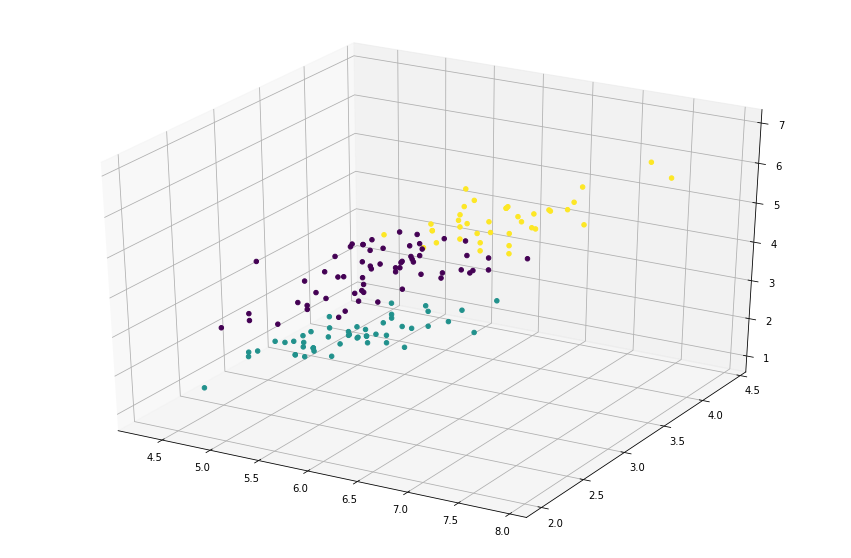

In [28]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()